### This jupyter notebook is used for simulating some algorithms for personal sound zone.
### namely ACC, AED, BACC_RD, BACC_RTE

### The simulation is based on the setting which corresponds the paper 
**"Time-domain acoustic contrast control design with response differential constraint in personal audio systems"**

In [29]:
import numpy as np
import pyroomacoustics as pra
import matplotlib.pyplot as plt
import librosa
import os
import LoudspeakerArray
import MicrophoneArray
from LoudspeakerArray import print_ArrayInfo, CircularArray10, SphericalArray40, LineArray8
from utils import sph2cart, calculateDirections, generate_circular_spk_array, generate_microphone_array_big, generate_control_field_circular, generate_line_spk_array, generate_control_field_line
from plot_tools import plot_array, verify_shapeofArray, plot_total, plot_loudspeaker_dir
from scipy.spatial import distance_matrix
from BACC_utils import *
print(os.getcwd())

/Users/wenmiao/Majority/Code/Paper_reproduction-main/Personal_Sound_Zone


In [30]:
situation = "Line"    

class config:
    # Speaker array type
    spkArray = LineArray8()           # SphericalArray40(), CircularArray10(), LineArray8
    # print_ArrayInfo(spkArray)
    
    # Bright field range and dark field range
    bright_field_xrange = [1.2, 1.8]      # from paper
    bright_field_yrange = [1.71, 2.27]
    distance_2mics = 0.2
    distance_2fields = 0.4
# plot_array(mic_pos_car, "Microphones")
# verify_shapeofArray(mic_pos_car)
## Plot the microphone array and loudspeaker array together, not for computing

    
    # The directivity of the loudspeaker 
    loudspeaker_dir = "OMNI"              #- HYPERCARDIOID, CARDIOD, OMNI

    # Setting for the simulating room
    max_order = 0                         # Maximum order for reflections
    absorption = 1.0                      # The absorption coefficient for all the walls in room
    fs = 4000                             # Sampling rate
    f = 2000                              # The up bound frequency
    N = 4096                              # The NFFT samples
    K = 800                               # The length of the RIR
    
    # ACC method
    method = "BACC_RTE"                    #- ACC, AED, BACC_RD
    
    # Hyperparameters 
    delta = None                          # For ACC
    alpha = None                          # For AED
    beta = None                           # For BACC_RD
    
    if method == "ACC":
        delta = 1e-5                      # The regularization of ACC
    elif method == "AED":
        alpha = 1897                      # The hyperparameter of AED
    elif method == "BACC_RD":
        beta = 0.5                        # The hyperparameter of BACC-RD
        J = 128                           # The length of filter
    elif method == "BACC_RTE":
        beta = 0.5                          
        a = 2                             # The interval between frequencies
        J = 128                           
    
    # Reproduction
    resolution = 60                       # 声场重建分辨率  
    distance_rep = 0                      # 重建位置偏移量

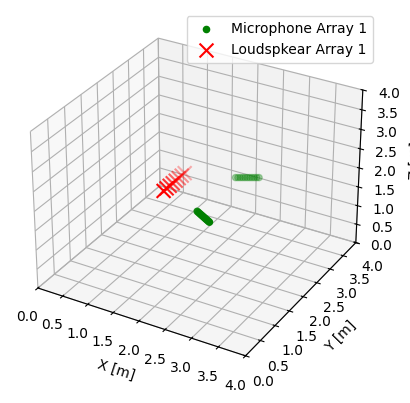

In [31]:

spk_pos_car = generate_line_spk_array(config)
# plot_array(spk_pos_car, "Loudspeakers") 
# verify_shapeofArray(spk_pos_car)

mic_pos_car = generate_microphone_array_big(config)
# plot_array(mic_pos_car, "Microphones")
# verify_shapeofArray(mic_pos_car)
## Plot the microphone array and loudspeaker array together, not for computing

room = pra.AnechoicRoom(fs=48000)
room_dim = [4,4,4]
room.add_microphone_array(pra.MicrophoneArray(np.array(mic_pos_car).T, room.fs))
for source_pos_car in spk_pos_car:
    room.add_source(source_pos_car)

room.compute_rir()
rt60_real = room.measure_rt60()
# print( "The measured RT60 is {}".format(rt60_real[1, 0]))
# plot_total(room_dim, [mic_pos_car],[spk_pos_car])

total_field = generate_control_field_line(config)
plot_total(room_dim, [total_field], [spk_pos_car])

In [32]:
## Simulate a room to get the corresponding room impulse response between mic array and loudspeaker array
bright_num = np.shape(total_field)[0]//2
bright_field = total_field[0:bright_num]
dark_field = total_field[bright_num:]
loudspeaker_dir = pra.directivities.DirectivityPattern[config.loudspeaker_dir]
target_point = np.mean(bright_field, axis=0)
directions = calculateDirections(spk_pos_car, target_point)


room_dim = [4,4,4]

room = pra.ShoeBox(room_dim, fs=config.fs, max_order=config.max_order, absorption=config.absorption)
room.add_microphone_array(pra.MicrophoneArray(np.array(total_field).T, room.fs))
for i, source_pos_car in enumerate(spk_pos_car):
    azimuth = np.arctan2(directions[i][1], directions[i][0])
    orientation = pra.directivities.DirectionVector(azimuth=azimuth, degrees=False)
    dir = pra.directivities.CardioidFamily(orientation=orientation, pattern_enum=loudspeaker_dir)
    room.add_source(position= source_pos_car, directivity= dir)


room.compute_rir()
rt60_real = room.measure_rt60()
print( "The measured RT60 is {}".format(rt60_real[1, 0]))

# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')
# for i, (pos, dir) in enumerate(zip(spk_pos_car, directions)):
#     ax.quiver(pos[0], pos[1], pos[2], dir[0], dir[1], dir[2], length=0.3, normalize=True)
# bright_field_center = np.mean(bright_field, axis=0)
# ax.scatter(bright_field_center[0], bright_field_center[1], bright_field_center[2], c='red', marker='o', label='Center of bright field')
# ax.set_xlabel('X')
# ax.set_ylabel('Y')
# ax.set_zlabel('Z')
# ax.set_title('Spatial Distribution of Directions')
# ax.legend()
# plt.show()

The measured RT60 is 0.008000000000000002


In [33]:
## Transfer the RIR to Transfer function
freq_bins = np.fft.fftfreq(config.N, 1/config.fs)[:config.N//2]  
# max_bin = np.argmax(freq_bins >= config.f)  
max_bin = config.f

TF_total_bright = []
TF_total_dark = []

bright_len = len(bright_field)
dark_len = len(dark_field)
pad_zeros_num = 0


for i in range(bright_len+dark_len):
    for j in range(len(spk_pos_car)):
        if  len (room.rir[i][j] < config.K):
            pad_zeros_num = config.K - len(room.rir[i][j])
            pad_zeros_part = np.zeros(pad_zeros_num)
            temp = np.concatenate([room.rir[i][j], pad_zeros_part], axis=None)
            room.rir[i][j] = temp

for i in range(len(spk_pos_car)):
    TF_temp_bright = np.zeros((bright_len, max_bin), dtype=complex)
    TF_temp_dark = np.zeros((dark_len, max_bin), dtype=complex)
    for j in range(bright_len):
        TF_b = np.fft.fft(room.rir[j][i], config.N)
        TF_temp_bright[j] = TF_b[:max_bin]
    for k in range(dark_len):
        TF_d = np.fft.fft(room.rir[bright_len + k][i], config.N)
        TF_temp_dark[k] = TF_d[:max_bin]
    TF_total_bright.append(TF_temp_bright)
    TF_total_dark.append(TF_temp_dark)

In [34]:
## Implementing the PSZ algorithm
if (config.method == 'ACC') or (config.method == 'AED'):
    TF_total_bright = np.array(TF_total_bright).T
    TF_total_dark = np.array(TF_total_dark).T
    w_total = []
    for k in range(max_bin):
        TF_array_b = TF_total_bright[k]
        RB = np.transpose(TF_array_b.conj()) @ TF_array_b
        TF_array_d = TF_total_dark[k]
        RD = np.transpose(TF_array_d.conj()) @ TF_array_d
        if (config.method == 'ACC'):
            matrix = np.linalg.pinv(RD + config.delta * np.eye(np.size(RD.shape[0]), dtype=complex)) @ RB
            filter_save_name = f"ACC_{situation}"
        elif config.method == "AED":
            matrix = (RB - config.alpha * RD) 
            filter_save_name = f"AED_{situation}"
        eigenvalues, eigenvectors = np.linalg.eig(matrix)
        max_eigenvalue_index = np.argmax(eigenvalues)
        max_eigenvalue = eigenvalues[max_eigenvalue_index]
        corresponding_eigenvector = eigenvectors[:, max_eigenvalue_index]

        w = corresponding_eigenvector
        w_total.append(w)
    w_total = np.array(w_total)

elif (config.method == "BACC_RD") or (config.method == 'BACC_RTE'):
    K = config.K
    J = config.J
    M = J
    N = K + J -1 
    MB = bright_len
    MD = dark_len
    L = len(spk_pos_car)

    HB = build_H(MB, L, N, room.rir, J)
    HD = build_H(MD,L ,N, room.rir, J, MB)

    RB = HB.T@HB/MB
    RD = HD.T@HD/MD
    if config.method == "BACC_RD":
        Constain_term = build_RD(HB, L=L, M=M, K=config.K, MB=MB, fs= config.fs, J_freqs = config.f)
        filter_save_name = f"BACC_RD_{J}_{situation}"
    elif config.method == "BACC_RTE":
        Constain_term = build_RTE(HB,L,M,config.K,MB,config.fs,config.f,config.a)
        filter_save_name = f"BACC_RTE_{J}_{situation}"
    w_opt, contrast = solve_BACC(RB, RD, Constain_term, beta=0.5, delta=1e-6)
    print(f"Optimal filter coefficients shape : {w_opt.shape}")
    print(f"Maximum acoustic contrast : {contrast:.2f} dB")
    w_total = []
    for l in range(len(spk_pos_car)):
        w_l = w_opt[J*l : J*(l+1)]
        w_temp_FD = np.fft.fft(w_l, config.N)
        w_total.append(w_temp_FD)
    w_total = np.array(w_total).transpose()

np.save(filter_save_name, w_total)

Optimal filter coefficients shape : (1024,)
Maximum acoustic contrast : 31.84+0.00j dB


In [35]:
## reproduce the sound field in another room
resolution = config.resolution
X = np.linspace(1, 3.5, resolution)
Y = np.linspace(1, 3, resolution)
x_pred, y_pred = np.meshgrid(X,Y)
x_pred = x_pred.reshape(-1)
y_pred = y_pred.reshape(-1)
z_pred = np.zeros(len(x_pred))
points = np.transpose([x_pred, y_pred, z_pred])

bright_field_rep = bright_field + np.array([config.distance_rep, 0, 0])
dark_field_rep = dark_field + np.array([config.distance_rep, 0, 0])
total_points = np.concatenate((bright_field_rep, dark_field_rep, points))

room_dim = [4,4,4]

room = pra.ShoeBox(room_dim, fs=config.fs, max_order=config.max_order, absorption=config.absorption)
room.add_microphone_array(pra.MicrophoneArray(np.array(total_points).T, room.fs))

loudspeaker_dir = pra.directivities.DirectivityPattern[config.loudspeaker_dir]
target_point = np.mean(bright_field, axis=0)
directions = calculateDirections(spk_pos_car, target_point)

for i, source_pos_car in enumerate(spk_pos_car):
    azimuth = np.arctan2(directions[i][1], directions[i][0])
    orientation = pra.directivities.DirectionVector(azimuth=azimuth, degrees=False)
    dir = pra.directivities.CardioidFamily(orientation=orientation, pattern_enum=loudspeaker_dir)
    room.add_source(position=source_pos_car, directivity= dir)
    

room.compute_rir()
rt60_real = room.measure_rt60()
print( "The measured RT60 is {}".format(rt60_real[1, 0]))

TF_total_p = []
TF_rep_b = []
TF_rep_d = []
for i in range(len(spk_pos_car)):
    TF_temp_p = np.zeros((len(points),config.f), dtype=complex)
    TF_temp_bright = np.zeros((len(bright_field_rep), config.f), dtype=complex)
    TF_temp_dark = np.zeros((len(dark_field_rep), config.f), dtype=complex)
    for j in range(bright_len):
        TF_b = np.fft.fft(room.rir[j][i], config.N)
        TF_temp_bright[j] = TF_b[:max_bin]
    for k in range(dark_len):
        TF_d = np.fft.fft(room.rir[bright_len + k][i], config.N)
        TF_temp_dark[k] = TF_d[:max_bin]
    for l in range(len(points)):
        TF_p = np.fft.fft(room.rir[bright_len + dark_len + l][i], config.N)
        TF_temp_p[l] = TF_p[:config.f]
    TF_total_p.append(TF_temp_p)
    TF_rep_b.append(TF_temp_bright)
    TF_rep_d.append(TF_temp_dark)
TF_total_p = np.array(TF_total_p).T
TF_rep_b = np.array(TF_rep_b).T
TF_rep_d = np.array(TF_rep_d).T

The measured RT60 is 0.008000000000000002


/var/folders/cp/qh076_c520z12k3l0807brbr0000gn/T/ipykernel_51368/1008753780.py:6: ComplexWarning: Casting complex values to real discards the imaginary part
  pB[f] = TF_rep_b[f,control_point_index,:] @ w_total[f]


Text(0.5, 1.0, 'Frequency Response')

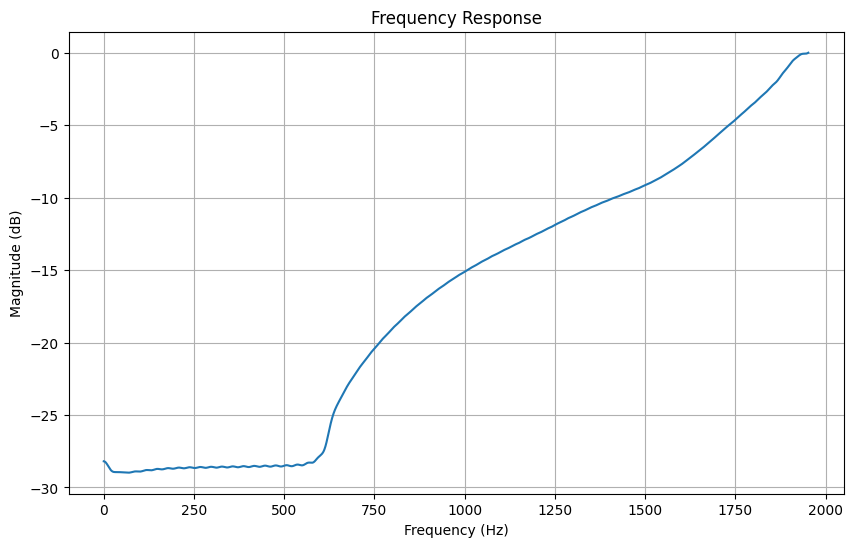

In [36]:
## The frequency Response of the algorithm 
control_point_index = 1
Frequency_Response = []
pB = np.zeros(config.f)
for f in range(config.f):
    pB[f] = TF_rep_b[f,control_point_index,:] @ w_total[f]
    # 计算幅频响应（单位：dB）
magnitude_response_db = 20 * np.log10(np.abs(pB))

# 计算相频响应（单位：弧度）
phase_response = np.angle(pB)

# 如果需要多个控制点的频响
num_control_points = 8
pB_all = np.zeros((config.f, num_control_points), dtype=complex)
for f in range(config.f):
    for point in range(num_control_points):
        pB_all[f, point] = TF_rep_b[f, point, :] @ w_total[f]

# 计算平均频响（如果需要）
average_magnitude_response_db = 20 * np.log10(np.mean(np.abs(pB_all), axis=1))
plt.figure(figsize=(10, 6))
plt.plot(freq_bins[0:2000], average_magnitude_response_db - max(average_magnitude_response_db))
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude (dB)')
plt.grid(True)
plt.title('Frequency Response')

Acoustic Contrast at 100 Hz: 25.11 dB
Acoustic Contrast at 500 Hz: 28.01 dB
Average Acoustic Contrast in the frequency range (0, 2000): 34.99 dB


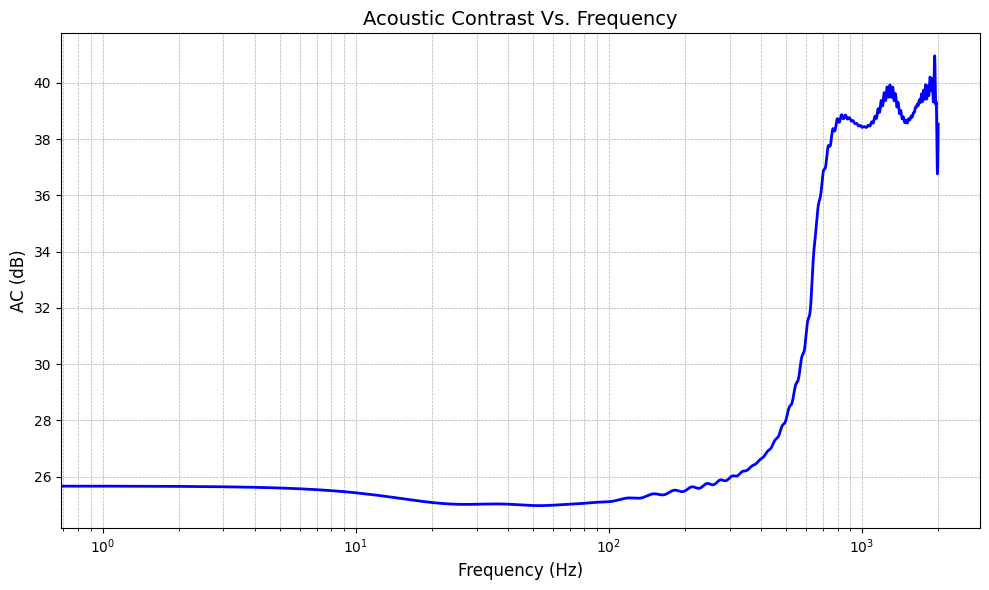

In [37]:
## The Acoustic Contrast between bright area and dark area
AC_total = []
selected_frequencies = [100, 500, 2000]
for i in range(config.f):
    pB = TF_rep_b[i] @ w_total[i]
    EB = np.conj(pB).T @ pB
    pD = TF_rep_d[i] @ w_total[i]
    ED = np.conj(pD).T @ pD
    AC = 10 * np.log10(np.abs(EB) / np.abs(ED))

    if i in selected_frequencies:
        print(f"Acoustic Contrast at {i} Hz: {AC:.2f} dB")

    AC_total.append(AC)

plt.figure(figsize=(10, 6))
plt.semilogx(range(config.f), AC_total, linewidth=2, color='b')
plt.grid(True, which="both", linestyle='--', linewidth=0.5)
plt.title("Acoustic Contrast Vs. Frequency", fontsize=14)
plt.xlabel("Frequency (Hz)", fontsize=12)
plt.ylabel('AC (dB)', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()

average_AC = np.mean(AC_total)
print('Average Acoustic Contrast in the frequency range (0, {}): {:.2f} dB'.format(config.f, average_AC))

plt.show()

In [38]:
G_pred = np.array(TF_total_p)
p_pred_dB = []
for i in range(config.f):
    p_pred_temp = G_pred[i] @ w_total[i]
    p_pred_dB_temp = 20*np.log10(np.abs(p_pred_temp))
    p_pred_dB.append(p_pred_dB_temp)
w_total = np.array(w_total)


38.421901445253155


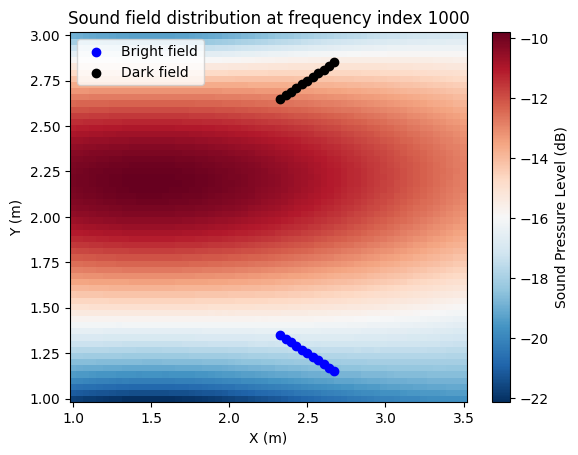

In [41]:
# get the sound field distribution
i = 1000
print(AC_total[i])
p_pred_dB_reshape = np.array(p_pred_dB[i]).reshape(resolution, resolution)
plt.figure()
plt.pcolor(X, Y, p_pred_dB_reshape, cmap='RdBu_r')
# plt.pcolor(X, Y, p_pred_dB_reshape, cmap='inferno')
plt.colorbar(label='Sound Pressure Level (dB)')
plt.scatter(bright_field[:, 0], bright_field[:, 1], c='blue', label='Bright field')
plt.scatter(dark_field[:, 0], dark_field[:, 1], c='k', label='Dark field')
plt.xlabel('X (m)')
plt.ylabel('Y (m)')
plt.legend()
plt.title(f'Sound field distribution at frequency index {i}')
plt.show()